# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "yunzhi"
ln1 = "wu"
fn2 = "xiao"
ln2 = "pan"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_wu_yunzhi_and_pan_xiao.ipynb


Some imports

In [3]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
import sklearn

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{aligned}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>


<div class="alert alert-warning">
    <b>ANSWER</b>
     <ul>

\begin{align}
\frac{1}{2}\Vert tx+(1-t)y \Vert^2 &=\frac{1}{2}\sum_{i=1}^d(t^2x_i^2+(1-t)^2y_i^2+2t(1-t)x_iy_i)\\
&= \frac{1}{2}\sum_{i=1}^d(t^2(x_i-y_i)^2+2ty_i(x_i-y_i)+y_i^2)\\
&=\frac{1}{2}\sum_{i=1}^d((x_i-y_i)t(t(x_i-y_i)+2y_i)+y_i^2)\\
&\leq \frac{1}{2}\sum_{i=1}^d((x_i-y_i)t(x_i+y_i)+y_i^2)\\
&=\frac{1}{2}\sum_{i=1}^d(t(x_i^2-y_i^2)+y_i^2)\\
&=\frac{1}{2}(t\Vert x\Vert ^2+(1-t)\Vert y\Vert ^2)
\end{align}
For any $t\in[0,1],\quad x,y\in R^d$,<br\>
Thus, $\frac{1}{2}\Vert w \Vert^2$ is convex, <br/>
<br/>
$ - \rho$ and $ \frac{1}{\nu n} \sum_{i=1}^n \xi_i$ are linear, thus convex.<br/>
<br/>
The sum of convex functions are still convex, so the objective function is convex. <br/>
<br/>
Moreover, the constraints $\quad \langle w, x_i \rangle \geq \rho - \xi_i,\quad 1 \leq i \leq n$ and $\quad \xi_i \geq 0, \quad 1 \leq i \leq n$ are convex. So the problem $(\mathcal{P})$ is convex.
</ul>
</div>


<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.


<div class="alert alert-warning">
    <b>ANSWER</b>
     <ul>
      $\mathcal{L}(w, \rho, \mu, \alpha, \xi) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n\mu_i(\rho-\xi_i-\langle w,x_i\rangle) - \sum_{i=1}^n \alpha_i\xi_i$, where $\alpha_i\geq0,\mu_i\geq0, i=1,2,...,n$ are Lagrangian multiplers.<br\>

<br/>
The dual problem is $max_{\alpha,\mu} min_{w,\rho,\xi}\mathcal{L}(w, \rho, \mu, \alpha, \xi)\quad s.t. \alpha_i\geq0,\mu_i\geq0,~i=1,2,...,n$ <br/>

<br/>

Do derivation to $\mathcal{L}(w, \rho, \mu, \alpha, \xi)$ by $w,\rho,\xi$ and let them equal to 0, get:<br/>
<br/>


$$\left\{
 \begin{array}{lll}
 \frac{1}{\nu n}-\mu_i-\alpha_i=0 & i=1,...,n
 \\
 w - \sum_{i=1}^n\mu_i x_i = 0
 \\
 \sum_{i=1}^n\mu_i=1
 \end{array}
 \right .$$
<br/>
 
 
Put them back into the Lagrangian, then the Dual problem can be written as:<br/>
<br/>

 $max_{\alpha\geq0,\mu\geq0}\frac{1}{2}\Vert \sum_{i=1}^n\mu_i x_i\Vert^2-\rho+\frac{1}{\nu n}\sum_{i=1}^n\xi_i - \langle \sum_{i=1}^n\mu_i x_i,\sum_{i=1}^n\mu_i x_i\rangle+\rho\sum_{i=1}^n\mu_i-\sum_{i=1}^n\mu_i\xi_i-\sum_{i=1}^n\alpha_i\xi_i\\=max_{\alpha\geq0,\mu\geq0}-\frac{1}{2}\Vert\sum_{i=1}^n\mu_ix_i\Vert^2\quad s.t.~ \sum_{i=1}^n\mu_i=1,\quad \mu_i + \alpha_i = \frac{1}{\nu n}$,<br\>
<br/>
 
 equivalent to <br/>
 
<br/>
 
 $min_{\mu}\frac{1}{2}\Vert\sum_{i=1}^n\mu_ix_i\Vert^2\quad s.t.~0\leq\mu_i\leq \frac{1}{\nu n},~\sum_{i=1}^n\mu_i=1$<br/>
 
<br/>
 
 equivalent to:<br/>
 
<br/>
 
 $$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </ul>
</div>


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>


<div class="alert alert-warning">
    <b>ANSWER</b>
     <ul>
      <li>Since we assume that the strong duality holds, then $p=d$, and the saddle point is the optimizer. As given above, the saddle point satisfies $w - \sum_{i=1}^n\mu_i x_i = 0$. Thus, given the estimated $\mu$, it must be the component of the saddle point, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$</li>
    </ul>
</div>

## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

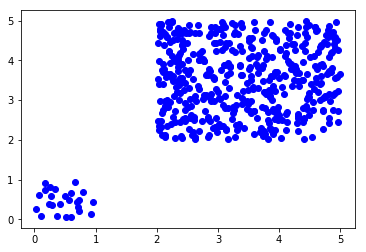

In [4]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [5]:
import cvxopt


def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
 
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [7]:
# TODO
def ocsvm_solver(K, nu=0.1):
    n = K.shape[0]
    P = K
    q = np.zeros(n)
    A = np.ones((1,n))
    b = np.ones((1,1))
    C = 1./(nu * n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K,0.1)
print("Number of support vectors: %s" % idx_support.size)

Number of support vectors: 50


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

In [8]:
# TODO
mu_support, idx_support = ocsvm_solver(K,0.1)
w = mu_support.dot(X[idx_support])
print(w)

[ 1.37631398  1.37252753]


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

<div class="alert alert-warning">
    <b>ANSWER</b>
     <ul>
      <li>Since $\rho$ is a constant, so it can be computed using any $x_i$ where the corresponding index i satisfies $0 < \mu_i < \frac{1}{\nu n}$.</li>
      <li>The $\mu$(support) derived by ocsvm_solver contains $\mu_i$ which satisfies $\mu_i>0$.</li>
      <li>Wheras most of them do not satisfies $\mu_i < \frac{1}{\nu n}$, which means we have $\mu_i = \frac{1}{\nu n}$ for most of them.</li>
      <li>We use the smallest $\mu_i$ among $\mu$(support), which should be strictly smaller than $\frac{1}{\nu n}$, to compute $\rho$.</li>
    </ul>
</div>
**IMPLEMENTATION:** See the code below

In [9]:
# TODO
def compute_rho(K, mu_support, idx_support):
    # TODO
    idx_mu_min = mu_support.argmin() # get the index of the mu which satisfies the inequality constraint
    K_support = K[idx_support][:, idx_support]
    rho = mu_support.dot(K_support)[idx_mu_min]
    return rho

computed_rho = compute_rho(K, mu_support, idx_support)
print(computed_rho)

6.75709879671


<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [10]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
2.16400352023
2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

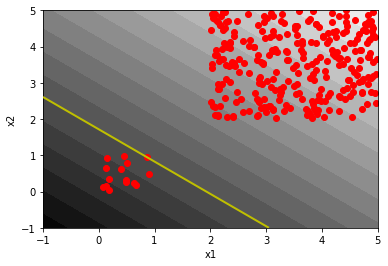

In [11]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function
    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>ANSWER</b>
     <ul>
      <li>None of these algorithms could be applied to solve this dual problem because they can only be applied to unconstrained problems.</li>
    </ul>
</div>

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>ANSWER</b>
      $$G^tG=K(X,X)$$
      so 
      \begin{align*}
      y(x) &= \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace\\
      &= \mathrm{sign}(\sum_{i=1}^n\mu_i K(x_i,x)-\sum_{i=1}^n\mu_i K(x_i,x_j)),\quad \forall j \quad s.t.\mu_i\in(0,\frac{1}{\nu n})  \\
      &= \mathrm{sign}(\mu ^T K(x_:,x)-\mu ^T K(x_:,x_j)),\quad \forall j \quad s.t.\mu_i\in(0,\frac{1}{\nu n})  
      \end{align*}
</div>

We will use another dataset to evaluate this:

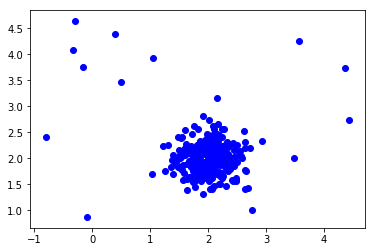

In [12]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [13]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma*np.linalg.norm(X1[i]-X2[j])**2)  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

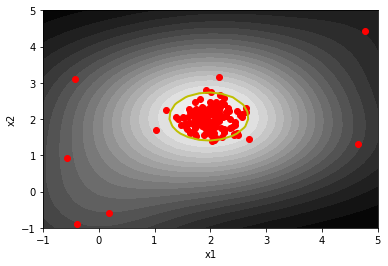

In [14]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)

plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>


<div class="alert alert-warning">
    <b>ANSWER</b>
     <ul>
      $\mathcal{L}(w, \mu, \alpha, \xi) = \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i + \sum_{i=1}^n\mu_i(1-\xi_i-\langle w,x_i\rangle) - \sum_{i=1}^n \alpha_i\xi_i$, where $\alpha_i\geq0,\mu_i\geq0, i=1,2,...,n$ are Lagrangian multiplers.<br\>

<br/>
The dual problem is $max_{\alpha,\mu} min_{w,\xi}\mathcal{L}(w, \mu, \alpha, \xi)\quad s.t. \alpha_i\geq0,\mu_i\geq0,~i=1,2,...,n$ <br/>

<br/>

Do derivation to $\mathcal{L}(w, \mu, \alpha, \xi)$ by $w,\xi$ and let them equal to 0, get:<br/>
<br/>


$$\left\{
 \begin{array}{lll}
 \frac{C}{n}-\mu_i-\alpha_i=0 & i=1,...,n
 \\
 w - \sum_{i=1}^n\mu_i x_i = 0
 \end{array}
 \right .$$
<br/>
 
 
Put them back into the Lagrangian, then the Dual problem can be written as:<br/>
<br/>

 $max_{\alpha\geq0,\mu\geq0}\frac{1}{2}\Vert \sum_{i=1}^n\mu_i x_i\Vert^2+\frac{C}{n}\sum_{i=1}^n\xi_i - \langle \sum_{i=1}^n\mu_i x_i,\sum_{i=1}^n\mu_i x_i\rangle+\sum_{i=1}^n\mu_i-\sum_{i=1}^n\mu_i\xi_i-\sum_{i=1}^n\alpha_i\xi_i\\=max_{\alpha\geq0,\mu\geq0}-\frac{1}{2}\Vert\sum_{i=1}^n\mu_ix_i\Vert^2+\sum_{i=1}^n\mu_i
\quad s.t.~\mu_i + \alpha_i = \frac{C}{n},~\mu_i \geq 0, \alpha_i \geq 0$<br\>
<br/>
 
 equivalent to <br/>
 
<br/>
  $$
  (\mathcal{D}):
\left\{
\begin{array}{lll}
 min_{\mu}\frac{1}{2}\Vert\sum_{i=1}^n\mu_ix_i\Vert^2 - \sum_{i=1}^n\mu_i\quad
 \\
 s.t.~0\leq\mu_i\leq \frac{C}{n}
 \end{array}
\right .
  $$
<br/>
 
 equivalent to:<br/>
 
<br/>
 
 $$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
\end{array}
\right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </ul>
</div>


<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



<div class="alert alert-warning">
    <b>ANSWER</b>
        $$
        (\mathcal{D}):
        \left\{
        \begin{array}{lll}
        \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
        \\
        \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
        \end{array}
        \right .
        $$
Then the dual problem can be rewritten as 
    $$
    (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
    $$
Where:  
\begin{align}
& f(\mu) = \frac{1}{2}\mu^{\top}GG^{\top}\mu - \mu^{\top} 1_n\\
& g(\mu) = i_{0 \leq x \leq \frac{C}{n}}(\mu) = \sum_{i=1}^n i_{0 \leq x \leq \frac{C}{n}}(\mu_i)\\
\end{align}
and

$$
i_{0 \leq x \leq \frac{C}{n}}(x):
        \left\{
        \begin{array}{lll}
        0 \quad if \ \ 0 \leq x \leq \frac{C}{n}
        \\
        \inf \quad otherwise
        \end{array}
        \right .
$$
</div>

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

In [15]:
X = make_blob_dataset(100)
K = kernel(X, X)
K_rbf = rbf_kernel(X, X)

In [16]:
c = 10
n = K.shape[0]
C = c / n
n_iter = 500
mu0 = np.ones(n)

<div class="alert alert-warning">
<b>(1)</b>
Our own solver based on the QP function in cvxopt
</div>

In [17]:
def qp1(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, solver='mosec')
 
    return np.ravel(solution['x']),np.ravel(solution['dual objective'])

In [18]:
def solver_1(K, eps, c=10):
    n = K.shape[0]
    P = K
    q = - np.ones(n)
    A = None
    b = None
    C = c / n
    mu,obj = qp1(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support, obj

<div class="alert alert-info">
<b>**Preparations:**</b>
<ul>
(1) The inspector function to keep track of the algorithms.<br>
(2) The definitions of the objective function (f) and the penalty function (g) of the optimization problem.<br>
(3) The get_result function to show the output of the algorithm.
</ul>

**Remark**<br>
One evaluation of the approximation is the $\rho$ using the compute_rho function:<br>
We must have $\rho \rightarrow 1$.
</div>

In [19]:
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)
print("The true objective value is:",obj_true[0])

The true objective value is: -0.160084861507


In [20]:
import time

def inspector(loss_fun, obj_real, x_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 

    def inspector_cl(xk):
        obj = loss_fun(xk) - obj_real
        err = norm(xk - x_real)
        tim = time.time()-t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
    
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(10) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(10), ("%.4e" % obj).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % tim).rjust(10)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing
    return inspector_cl

In [21]:
#f
def f(x):
    x = np.asarray(x)
    return 0.5 * x.T.dot(K).dot(x) - np.sum(x) 

#grad_f
def grad_f(x):
    x = np.asarray(x)
    return K.dot(x) - np.ones(x.shape[0])

# g
def g(x):
    x = np.asarray(x)
    if (x >= 0).all() and (x <= C).all():
        return 0
    else:
        return 1e9

# proximate by coordinate
def proxi(xi):
    if xi >= 0 and xi <= C:
        return xi
    elif xi < 0:
        return 0
    else:
        return C

# proximate
def prox(x):
    p = []
    for i in range(x.shape[0]):
        p.append(proxi(x[i]))
    return np.asarray(p)


In [22]:
def func(x):
        x = np.asarray(x)
        if (x >= 0.).all() and (x <= C).all():
            return 0.5 * x.T.dot(K).dot(x) - np.sum(x) 
        else:
            return 1e9 

In [122]:
def get_result(mu):
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    rho = compute_rho(K, mu_support, idx_support)
    print("Rho:\t\t",rho)
    w = mu_support.dot(X[idx_support])
    print("w:\t\t",w)
    obj = func(mu)
    print("objective:\t",obj)
    print("Number of support vectors: %s" % idx_support.size)

<div class="alert alert-warning">
<b>(2.1)</b>
Our own solver of proximal gradient without acceleration
</div>

In [24]:
from numpy.linalg import norm

def ista(x0, x_true, f, grad_f, g, prox_g, eps=1e-30, n_iter=50, callback=None):
    """Proximal gradient descent algorithm (ISTA)
    """
    x = x0.copy()
    x_new = x0.copy()
    n_features = K.shape[0]
    lips = norm(K,2) # calculate the lipschitz constant
    step = 1./lips # calculate the step size 
    
    for k in range(n_iter):
        if norm(x - x_true) <= eps:
            break
        x = prox_g(x-step*grad_f(x))
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

<div class="alert alert-warning">
<b>(2.2)</b>
Own solver of proximal gradient with acceleration
</div>

In [25]:
def fista(x0, x_true, f, grad_f, g, prox_g, eps=1e-30, n_iter=50, callback=None):
    """Accelerated proximal gradient descent algorithm (FISTA)
    """
    x = x0.copy()
    z = x0.copy()
    x_new = x0.copy()
    t = 1.
    lips = norm(K,2) # calculate the lipschitz constant
    step = 1./lips # calculate the step size
    
    for k in range(n_iter):
        if norm(x - x_true) <= eps:
            break
        x_new = prox_g(z-step*grad_f(z))
        t_new = (1.+np.sqrt(1.+4*t**2))/2.
        z_new = x_new + (t-1.)/t_new *(x_new-x)
        
        x = x_new
        z = z_new
        t = t_new
        
        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

<div class="alert alert-warning">
<b>(3)</b>
Own version of coordinate descent
</div>

In [26]:
def cd(x0, x_true, f, grad_f, g, prox_g, eps=1e-30, n_iter=50, callback=None):
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = K.shape
    L = K
    grad = grad_f(x)
    
    for k in range(n_iter):
        if norm(x - x_true) <= eps and callback is not None: 
            callback(x)
            break
        i = np.random.randint(0, n_features)
        x_new[i] = proxi((x[i] - grad[i]/L[i,i]))
        grad = grad - K[:,i]*x[i] + K[:,i]*x_new[i] # smart update
        x[i] = x_new[i]
        
        # Update metrics after each iteration.
        if k % n_features == 0 and callback is not None: 
            callback(x)
    return x

<div class="alert alert-danger">
**Remark:**
For Coordinate descent, we compute the gradient of one dimension at each time, so when we compare the iteration of the algorithms, we have:

1 iteration of ISTA = n_features iterations of CD
</div>

<div class="alert alert-warning">
<b>(4)</b>
An L-BFGS-B solver using scipy.optimize.fmin_l_bfgs_b
</div>

In [27]:
from scipy.optimize import fmin_l_bfgs_b
bfgs_inspector = inspector(func, obj_true, mu_true, verbose=True)
mu_bfgs, _, _ = fmin_l_bfgs_b(func, mu0, grad_f, approx_grad=0, bounds=[(0.,C)]*n,callback=bfgs_inspector)#, pgtol=1e-12, disp=1, m=10

    it     |    obj     |    err     |    time   
         0 | 1.6008e-01 | 1.5223e-01 | 2.4037e-03


<div class="alert alert-success">
<b>Evaluation:</b>
<br>
Evaluate the performance of your implementations in terms of computation time
</div>

# Outline
In the following parts, we are going to compare the four methods through their 
- rate of convergency
    * The rate of concergence is one of the most important character of an algorithm, showing the speed at which $x_k$'s approaches the optimum. It can be approximately predicted by the theoretical upperbounds, but sometimes the algorithm performs much better than the upperbound.
- time needed for each iteration
    * When the rate of convergency has been decided, the time needed for each iteration decides the total computation time, which we are always intersted in.
- total computation time  
- response to the change of C
    * C shows the penalty coefficient or the feasible domain. We will show its relation with support vectors number.
- response to the change of n
    * We are interested in the performance of the algorithms when K is very large. We predict that these characters will be affected by n:
        * time needed for each iteration: The complexity of each iteration is dependent on n.
        * total computation time
        * rate of convergence: rate of convergence of some methods depends on Lipschitez constant of $\triangledown f$ and $\Vert x_0-x_*\Vert$ which are affected by the dimension n. 
    * We expect L-BFGS to performe better in case of large n than other methods since it limits the memory of Hessian matrix from nXn to nXm where m is a fixed number.

<br\>

    

In [207]:
def display(eps, a):
    ista_inspector = inspector(func,obj_true, mu_true, verbose=False)
    mu_ista = ista(mu0, mu_true, f, grad_f, g, prox, eps=eps, n_iter=n_iter, callback=ista_inspector)
    fista_inspector = inspector(func,obj_true, mu_true, verbose=False)
    mu_fista = fista(mu0, mu_true, f, grad_f, g, prox, eps=eps, n_iter=n_iter, callback=fista_inspector)
    cd_inspector = inspector(func,obj_true, mu_true, verbose=False)
    mu_cd = cd(mu0, mu_true, f, grad_f, g, prox, eps=eps, n_iter=n_iter*K.shape[1], callback=cd_inspector)
    bfgs_inspector = inspector(func, obj_true, mu_true, verbose=False)
    mu_bfgs, _, _ = fmin_l_bfgs_b(func, mu0, grad_f, factr=1e1, bounds=[(0.,C)]*n,callback=bfgs_inspector)
    
    print("Data Size:",K.shape)
    print("The true objective value is:",obj_true[0])
    print("\n--------------------ISTA--------------------")
    get_result(mu_ista)
    print("\n-------------------FISTA--------------------")
    get_result(mu_fista)
    print("\n---------------------CD---------------------")
    get_result(mu_cd)
    print("\n------------------L-BFGS--------------------")
    get_result(mu_bfgs)
    print("\n--------------------------------------------")
    
    xs = [mu_ista, mu_fista, mu_cd, mu_bfgs]

    inspectors = [ista_inspector, fista_inspector, cd_inspector, bfgs_inspector]

    solvers = ["ISTA", "FISTA", "CD", "L-BFGS"]
    
    plt.figure(figsize=(15, 2))
    for i, name, x in zip(range(1, 5), solvers, xs):
        plt.subplot(1, 4, i)
        plt.stem(x)
        plt.ylim([0, a])
        plt.title(name)
        
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    
    for insp in inspectors:
        plt.semilogy(insp.obj, lw=2)
        plt.title("Loss", fontsize=18)
        plt.xlabel("Epoch", fontsize=14)
        plt.xlim([0,2000])
        plt.ylim([1e-10,1e0])
        plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for insp in inspectors:
        plt.semilogy(insp.err, lw=2)
        plt.title("Distance to optimum", fontsize=18)
        plt.xlim([0,2000])
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    
    plt.legend(solvers);

    print("Algorithm \t Time \t\t n_iter \t time_per_iter")
    for i in range(len(inspectors)):
        print(solvers[i],"\t\t%.4fs"%inspectors[i].timing[-1],"\t",len(inspectors[i].obj),"\t\t%.5fs"%(inspectors[i].timing[-1]/len(inspectors[i].obj)))



## N = 200, C = 10, Linear Kernel

In [209]:
X = make_blob_dataset(200)
K = kernel(X, X)
#K = rbf_kernel(X, X)
c = 6
n = K.shape[0]
C = c / n
n_iter = 1000000
mu0 = np.ones(n)
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)

Data Size: (200, 200)
The true objective value is: -0.135261013006

--------------------ISTA--------------------
Rho:		 0.99999452419
w:		 [ 0.35157325  0.25726756]
objective:	 -0.13526101202
Number of support vectors: 8

-------------------FISTA--------------------
Rho:		 0.999995657489
w:		 [ 0.35157358  0.25726792]
objective:	 -0.135261012021
Number of support vectors: 8

---------------------CD---------------------
Rho:		 0.999999999999
w:		 [ 0.35157484  0.25726928]
objective:	 -0.135261012022
Number of support vectors: 8

------------------L-BFGS--------------------
Rho:		 1.00000000495
w:		 [ 0.35157484  0.25726928]
objective:	 -0.135261012022
Number of support vectors: 8

--------------------------------------------
Algorithm 	 Time 		 n_iter 	 time_per_iter
ISTA 		1.6435s 	 7597 		0.00022s
FISTA 		0.1909s 	 878 		0.00022s
CD 		0.1515s 	 46 		0.00329s
L-BFGS 		0.0063s 	 50 		0.00013s


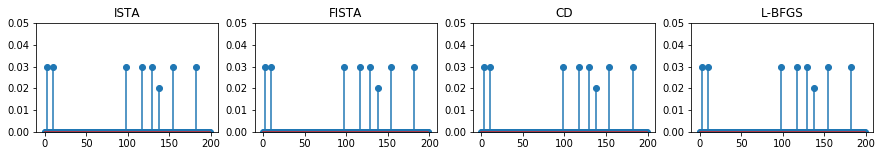

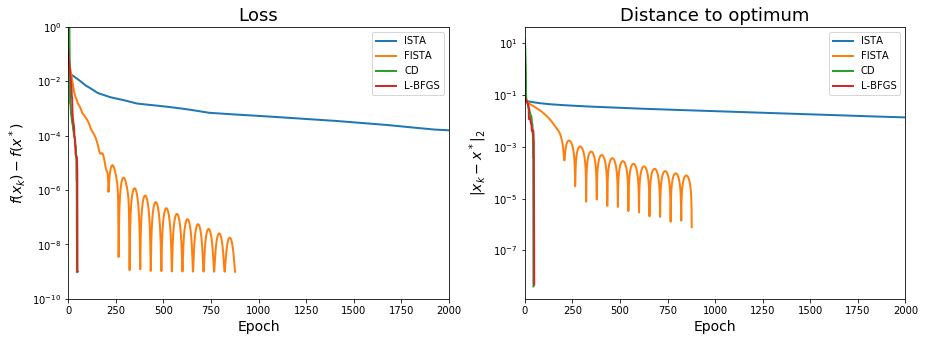

In [211]:
display(eps=1e-6, a=5e-2)

<div class="alert alert-info">
<h3>Observations (1):</h3>
<li> ISTA:
    <ul>
    <li> ISTA has the most iteration numbers among the 4 algorithms
    <li> However the computational time per iteration is fast
    </ul>
<li> FISTA:
    <ul>
    <li> FISTA has much less iterations than ISTA
    <li> The computational time per iteration is fast, the same as ISTA
    </ul>
<li> CD:
    <ul>
    <li> In terms of iteration, CD converges most quickly among the 4 algorithms.
    <li> CD has the most computational time per iteration
    </ul>
<li> L-BFGS:
    <ul>
    <li> In terms of computational time, L-BFGS converges the most quickly.
    <li> The computational time per iteration is the fastest among the 4 algorithms
    </ul>

<h3>Analysis</h3>

The theoretical rate of convergence of the four algorithms:<br\>
<br\>
<b>(1) L_BFGS</b>: The rate of convergency of L_BFGS is $O(\alpha^k)$ where $\alpha\in(0,1)$ is a constant, and k is the iteration number.<br\>
Illustration: As a quasi Newton Method, we have approximatly<br> $\Vert x_{k+1}-x_*\Vert \leq\gamma\Vert x_{k}-x_*\Vert^2,\quad \gamma >0$<br\>
$\rightarrow \Vert x_{k+1}-x_*\Vert \leq \gamma^{2k+1}\Vert x_0 - x_*\Vert ^{2(k+1)}$<br\>
<br\>
Thus, for $x_0$ in the domain that $\gamma \Vert x_0-x_*\Vert <1$, $x_k$ will converge to the optimum with a rate of $\alpha^{2(k+1)}$ where $\alpha \in(0,1)$ is a constant.<br\>
<br\>
<b>(2) CD (SDCA)</b>: $E(f(x_{k+1})-f(x_*))\leq \frac{n}{k/n+n}((1-\frac{1}{n})(f(x_0)-f(x_*))+0.5\Vert x_* - x_0\Vert ^2_L\sim O(\frac{1}{k})$ <br>where n is the dimension of $\mu$. However, this theoretical upper bound is too large, in practice, SDCA performes much better than $\frac{1}{k}$<br\>
<li>**Notice:** Each iteration shown on the graph of CD refers to n real iterations. Here k is the real iteration.<br\>
<br\>
<b>(3) FISTA</b>: $f(x_{k+1})-f(x_*)\leq\frac{2L\Vert x_0-x_*\Vert ^2}{(k+1)^2} \sim O(\frac{1}{k^2})$ where L is the Lipschitz constant of $\triangledown f$<br\>
<br\>
<b>(4) ISTA</b>: $f(x_{k+1})-f(x_*)\leq\frac{2L\Vert x_0-x_*\Vert ^2}{(k+1)} \sim O(\frac{1}{k})$ where L is the Lipschitz constant of $\triangledown f$<br\>
<br\>
So we can oberve the convergence L-BFGS>FISTA>ISTA$\simeq$ CD <br\>
<br\>
However, what we observed is CD>L-BFGS>FISTA>ISTA. That's probably because the upperbound of CD given by the theorem is too large, whereas the real performance of the algorithm is much better.<br\>    
As to the computation time of each iteration, the complexity of each iteration is as belows:<br\>
<b>(1) L_BFGS</b>: O(n*m), where m is the number of vectors we use each iteration.<br/>
<b>(2) CD (SDCA)</b>: O(n^2)<br\>
<b>(3) FISTA</b>: O(n^2)   <br\>
<b>(4) ISTA</b>:  O(n^2)<br\>
So L-BFGS has the least computation time for each iteration, but the computation time in each iteration cannot be derived directly from complexity since there are other costs, we cannot have a precise prediction.<br\>
</div>

### In the following, we change N and C and kernel and compare the results.
We tried the following parameters:<br>
N = 500, C = 10, Linear Kernel <br>
N = 1500, C = 10, Linear Kernel <br>
N = 200, C = 10, RBF Kernel <br>
N = 200, C = 1.1, RBF Kernel <br>
N = 200, C = 50, RBF Kernel


## N = 500, C = 10, Linear Kernel

In [212]:
X = make_blob_dataset(500)
K = kernel(X, X)
#K = rbf_kernel(X, X)
c = 10
n = K.shape[0]
C = c / n
n_iter = 100000
mu0 = np.ones(n)
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)

Data Size: (500, 500)
The true objective value is: -0.248300088044

--------------------ISTA--------------------
Rho:		 0.999993592349
w:		 [ 0.30304648  0.32318   ]
objective:	 -0.248300043095
Number of support vectors: 18

-------------------FISTA--------------------
Rho:		 0.999996672078
w:		 [ 0.3030475   0.32318091]
objective:	 -0.248300043098
Number of support vectors: 18

---------------------CD---------------------
Rho:		 1.0
w:		 [ 0.3030486   0.32318188]
objective:	 -0.248300043099
Number of support vectors: 18

------------------L-BFGS--------------------
Rho:		 1.0
w:		 [ 0.3030486   0.32318188]
objective:	 -0.248300043099
Number of support vectors: 18

--------------------------------------------
Algorithm 	 Time 		 n_iter 	 time_per_iter
ISTA 		7.9701s 	 14547 		0.00055s
FISTA 		0.4588s 	 765 		0.00060s
CD 		0.1536s 	 18 		0.00854s
L-BFGS 		0.0224s 	 61 		0.00037s


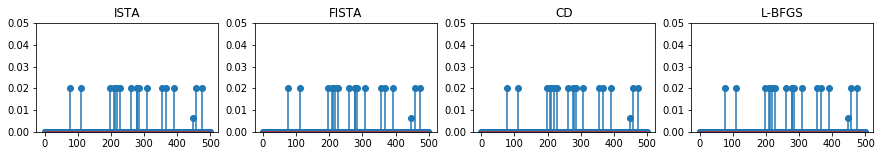

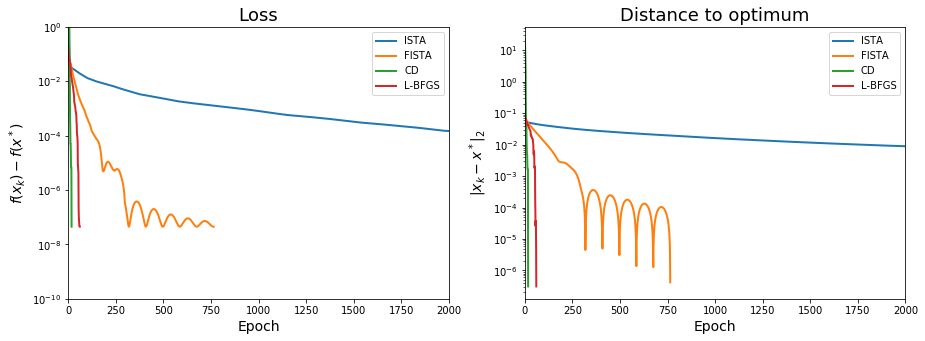

In [213]:
display(eps=1e-6, a=5e-2)

## N = 1500, C = 10, Linear Kernel

In [214]:
X = make_blob_dataset(1500)
K = kernel(X, X)
#K = rbf_kernel(X, X)
c = 10
n = K.shape[0]
C = c / n
n_iter = 100000
mu0 = np.ones(n)
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)

Data Size: (1500, 1500)
The true objective value is: -0.212673128354

--------------------ISTA--------------------
Rho:		 1.00001872827
w:		 [ 0.32470408  0.31331567]
objective:	 -0.212673121557
Number of support vectors: 48

-------------------FISTA--------------------
Rho:		 1.00001390892
w:		 [ 0.32470434  0.31331459]
objective:	 -0.212673121561
Number of support vectors: 48

---------------------CD---------------------
Rho:		 1.00000000001
w:		 [ 0.32470507  0.31331147]
objective:	 -0.212673121566
Number of support vectors: 48

------------------L-BFGS--------------------
Rho:		 1.0
w:		 [ 0.32470507  0.31331147]
objective:	 -0.212673121566
Number of support vectors: 48

--------------------------------------------
Algorithm 	 Time 		 n_iter 	 time_per_iter
ISTA 		88.0027s 	 36974 		0.00238s
FISTA 		1.9040s 	 612 		0.00311s
CD 		2.3952s 	 36 		0.06653s
L-BFGS 		0.1667s 	 78 		0.00214s


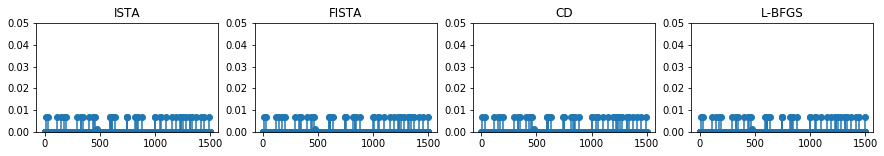

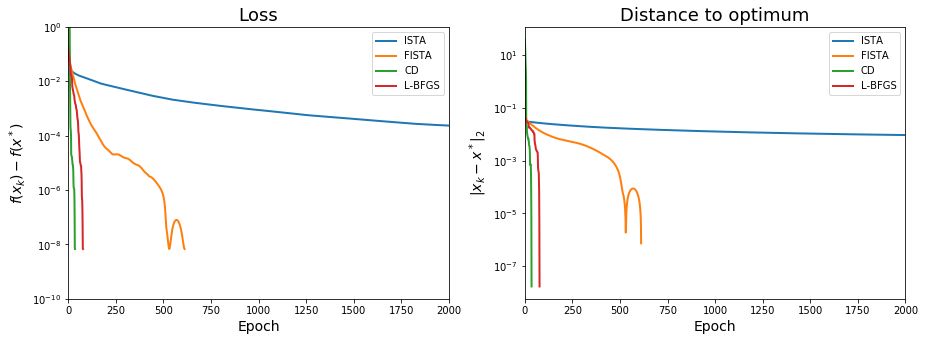

In [215]:
display(eps=1e-6, a=5e-2)

<div class="alert alert-info">
<h3>Observations (2):</h3>
<li> The iteration number
<ul>
    - ISTA: doubles<br>
    - FISTA: changes slightly<br>
    - CD: doubles<br>
    - L-BFGS: changes slightly<br\>
</ul>
<li> The computation time for each iteration increse at about 10 times.
<li> The total computation time increase.
<li> The results are all the same and give same support vectors.

<h3>Analysis</h3>
The rate of convergence of ISTA, FISTA, CD and L-BFGS depends on n through $\Vert f(x_*)-f(x_0)\Vert$ and $\Vert x_*-x_0\Vert$, and explicit n, but by comprehense effect, we get these phenomena. <br\>

The complexity of each iteration:
<br>
<b>(1) L_BFGS</b>: O(n*m), where m is the number of vectors we use each iteration.<br/>
<b>(2) CD (SDCA)</b>: O(n^2)<br\>
<b>(3) FISTA</b>: O(n^2)   <br\>
<b>(4) ISTA</b>:  O(n^2)<br\>
<br\>
Since we increased n 3 times, we expect to oberve an 3 more times of computation time for each iteration.
<br/>
The 4 methods converge to the same point.
</div>

## N = 200, C = 10, RBF Kernel

In [216]:
X = make_blob_dataset(200)
#K = kernel(X, X)
K = rbf_kernel(X, X)
kernel_1 = rbf_kernel
c = 10
n = K.shape[0]
C = c / n
n_iter = 100000
mu0 = np.ones(n)
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)

Data Size: (200, 200)
The true objective value is: -0.95040052768

--------------------ISTA--------------------
Rho:		 0.999983576035
w:		 [ 3.61486377  3.28868277]
objective:	 -0.950400495716
Number of support vectors: 32

-------------------FISTA--------------------
Rho:		 1.00003575327
w:		 [ 3.61493919  3.28883156]
objective:	 -0.950400496044
Number of support vectors: 32

---------------------CD---------------------
Rho:		 1.0
w:		 [ 3.61490104  3.28872483]
objective:	 -0.950400495838
Number of support vectors: 32

------------------L-BFGS--------------------
Rho:		 1.00000732232
w:		 [ 3.61486534  3.28876204]
objective:	 -0.950400496688
Number of support vectors: 32

--------------------------------------------
Algorithm 	 Time 		 n_iter 	 time_per_iter
ISTA 		1.4584s 	 7105 		0.00021s
FISTA 		0.1087s 	 486 		0.00022s
CD 		0.1854s 	 56 		0.00331s
L-BFGS 		0.0071s 	 60 		0.00012s


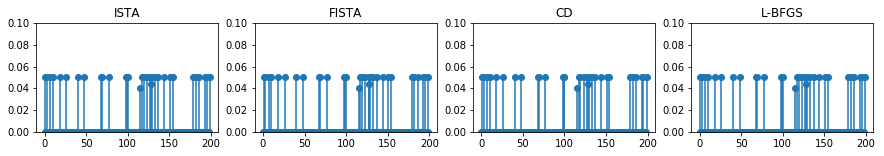

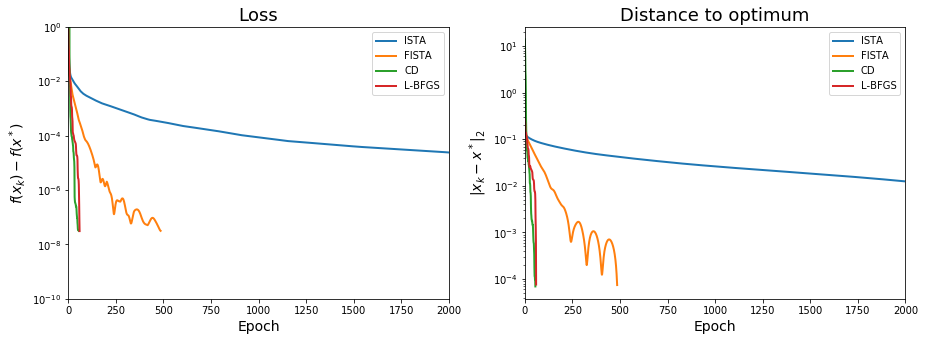

In [217]:
display(eps=8e-5, a=1e-1)

## N = 200, C = 1.1, RBF Kernel

In [222]:
X = make_blob_dataset(200)
#K = kernel(X, X)
K = rbf_kernel(X, X)
c = 1.1
n = K.shape[0]
C = c / n
n_iter = 100000
mu0 = np.ones(n)
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)

Data Size: (200, 200)
The true objective value is: -0.584036874812

--------------------ISTA--------------------
Rho:		 1.00006051307
w:		 [ 2.23297762  2.18178575]
objective:	 -0.584036696699
Number of support vectors: 198

-------------------FISTA--------------------
Rho:		 1.00009773767
w:		 [ 2.23305108  2.18185701]
objective:	 -0.584036700357
Number of support vectors: 198

---------------------CD---------------------
Rho:		 1.0
w:		 [ 2.23284701  2.18166308]
objective:	 -0.584036706908
Number of support vectors: 198

------------------L-BFGS--------------------
Rho:		 1.0
w:		 [ 2.23284701  2.18166308]
objective:	 -0.584036706908
Number of support vectors: 198

--------------------------------------------
Algorithm 	 Time 		 n_iter 	 time_per_iter
ISTA 		0.5954s 	 2395 		0.00025s
FISTA 		0.0372s 	 142 		0.00026s
CD 		0.1005s 	 26 		0.00387s
L-BFGS 		0.0049s 	 43 		0.00011s


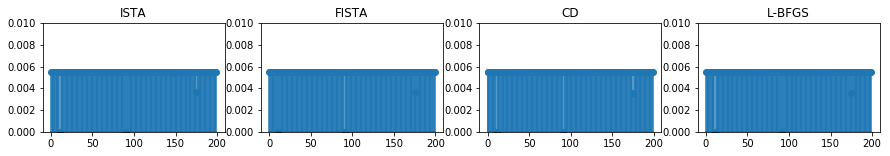

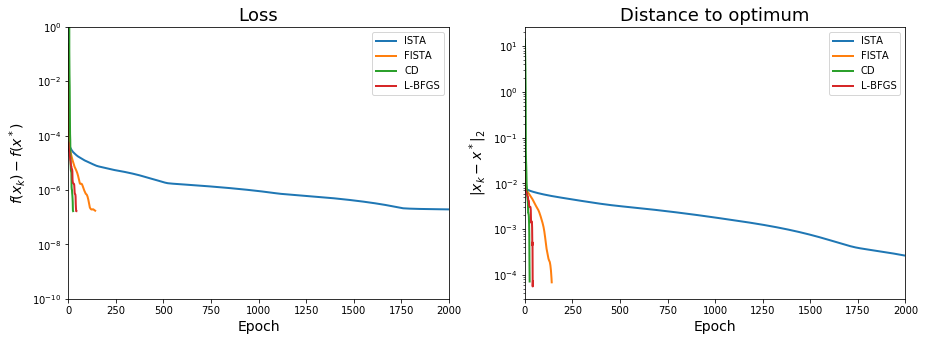

In [225]:
display(eps=8e-5, a=1e-2)

## N = 200, C = 50, RBF Kernel

In [226]:
X = make_blob_dataset(200)
#K = kernel(X, X)
K = rbf_kernel(X, X)
c = 50
n = K.shape[0]
C = c / n
n_iter = 100000
mu0 = np.ones(n)
mu_true,obj_true = qp1(K, - np.ones(n), None, None, C, verbose=False)

Data Size: (200, 200)
The true objective value is: -1.78514735542

--------------------ISTA--------------------
Rho:		 0.999920116137
w:		 [ 7.7110271   6.52575668]
objective:	 -1.78514733383
Number of support vectors: 12

-------------------FISTA--------------------
Rho:		 0.999942254693
w:		 [ 7.71108675  6.52578855]
objective:	 -1.78514733535
Number of support vectors: 12

---------------------CD---------------------
Rho:		 1.0
w:		 [ 7.71124233  6.52587169]
objective:	 -1.78514733702
Number of support vectors: 12

------------------L-BFGS--------------------
Rho:		 1.0
w:		 [ 7.71124233  6.52587169]
objective:	 -1.78514733702
Number of support vectors: 12

--------------------------------------------
Algorithm 	 Time 		 n_iter 	 time_per_iter
ISTA 		1.2212s 	 5363 		0.00023s
FISTA 		0.0484s 	 236 		0.00021s
CD 		0.1588s 	 55 		0.00289s
L-BFGS 		0.0047s 	 42 		0.00011s


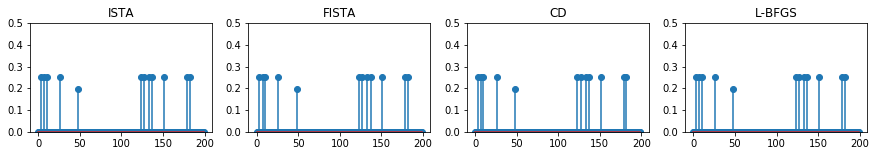

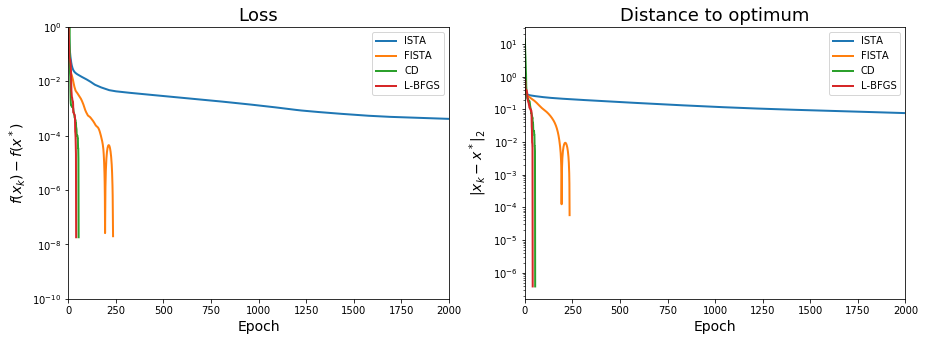

In [228]:
display(eps=8e-5, a=5e-1)

<div class="alert alert-info">
<h3>Observations (3):</h3>

<li> The smaller C is, we will have more support vectors.
<li> Computation time for each iteration don't change much.
<li> Iteration number doesn't have a explicit relation with C.

<h3>Analysis:</h3>
<li> Since n is fixed in this part, C decides the threshold of prox：$$
prox(x):
        \left\{
        \begin{array}{lll}
        x \quad if \ \ 0 \leq x \leq \frac{C}{n}
        \\
        \frac{C}{n} \quad if \ \ x > \frac{C}{n}
        \\
        0 \quad if \ \ x<0
        \end{array}
        \right .
$$. When C is smaller, $\mu$ has larger chance to be nonzero, while we know a nonzero $\mu$ accords to a support vector.
<li> The computation time for each iteration doesn't depend on C.
</div>

<div class="alert alert-success">
<b>Smart updates:</b>
<br>
Among the four optimization algorithms, Coordinate Descent 
</div>

<div class="alert alert-warning">
<h3>Smart Update</h3>
The CD we implemented is the SDCA and smart update was applied. <br><br>
* without smart update: $$\triangledown f(x_k)=K\cdot x - 1_n$$
-->Complexity for each iteration = O(n^2)<br><br>
* with smart update: $$\triangledown f(x_k)=\triangledown f(x_{k-1})-K_{:,i}*x_{k-1}(i)+K_{:,i}*x_k(i)$$

-->Complexity for each iteration = O(n)<br/>
<br\>
With smart update, we avoid calculating a matrix multiplication of (n,n) matrix and (n,1) vector.<br\>
Thus, the complexity for each iteration in CD: O(n^2) --> O(n)<br>
**Remark1:** The smart here is valid for all kernels. <br\>
**Remark2:** Here iteration refers to the real small iteration.
</div>